In [1]:
from AD_analysis import *
import Atmospheric_diffraction as atm_shift
import numpy as np
import matplotlib as mpl
import Integ_analysis as int_analysis

In [2]:
#Following function is used to plot the described graphs
def shift_plot_v0(input,output,conditions):
        ZA_range=input['ZA_range']

        #1) wavelength vs displacement for different ZA
        centre_shift=atm_diff.diff_shift(input['aperture_waveref'],output['airmasses'][0],input['guide_waveref'],conditions)

        fig, ax = plt.subplots(figsize=(10,7))
        airmasses=atm_diff.zenith_dist_to_airmass(ZA_range)


        if input['reposition'] == False: #If repositioned, wavelength reference centre is meaningless as relative position changes
            plt.axhline(-centre_shift.value,linewidth=0.5,color='red', label='Wavelength Reference Centre')
        for i in range(0,len(output['airmasses'])):
            plt.plot(output['wavelengths'],output['shifts'][i],label="ZA = %2.2f deg, airmass = %2.2f" %(ZA_range[i],airmasses[i]))

        
        plt.legend(loc='best')
        ax.set_ylabel('Displacement from Guiding Wavelength (arcsec)')

        ax.set_xlabel('Wavelength (nm)')
        plt.title('AD Shifts, 0.64um to 1.8um, Guide Wavelength = 1.2um')
        ax.set_ybound(-0.8,0.2)

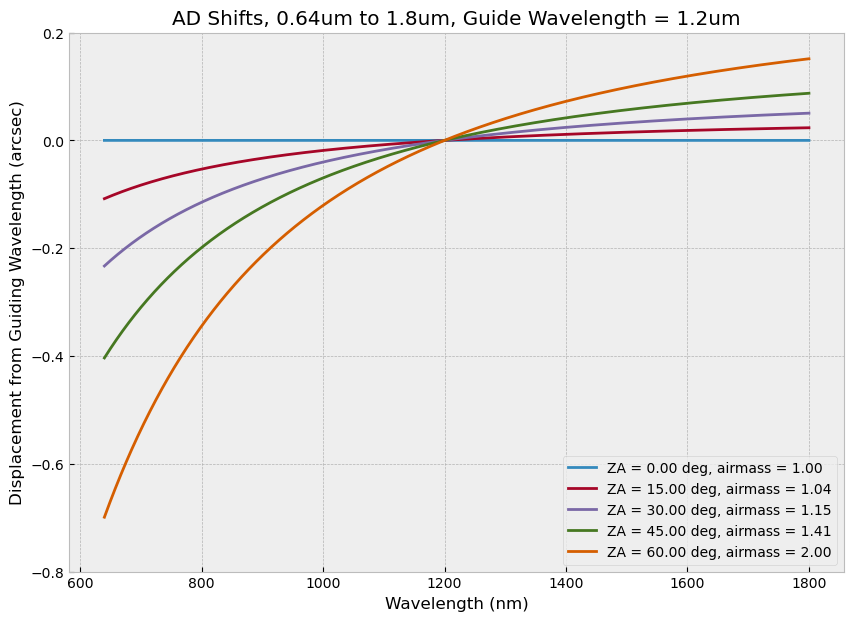

In [3]:
#Following is what is needed to plot the Wavelength vs Displacement and Displacement vs Airmass graphs. 
#Can switch out HA and ZA as needed in load_airmasses

analysis=AD_analysis() #Initialise class
# analysis.load_airmasses(HA_range=[0,1,2,3],targ_dec=10 * u.deg) #Generate airmasses (with HA)
analysis.load_airmasses(ZA_range=[0,15,30,45,60]) #Generate airmasses (with ZA)
analysis.output['wavelengths'] = np.arange(640,1800+1,1) * u.nm
analysis.calculate_shifts(aperture_waveref = 1.2 * u.micron,reposition=True,guide_waveref=1.2*u.micron,parallatic=False) #Calculates the shifts
shift_plot_v0(analysis.input,analysis.output,analysis.conditions) #Plot the graphs

In [4]:
#This function is used to calculate the average transmission over an integration.
#It takes the transmissions for each wavelength from multiple airmasses and averages them.
#This only is a true average of an integration if equally spaced HA have been used.
#This is not true with ZA, as ZA does not increase linearly with time
def observation_transmission(output):
    integ_transmission=[]
    for i in range(0,len(output['wavelengths'])):
        trans=0
        for o in range(0,len(output['transmissions'])):
            trans=trans+output['transmissions'][o][i]
        trans_mean=trans/len(output['transmissions'])
        integ_transmission.append(trans_mean)
    return integ_transmission

#Following function plots integration transmission average for single mode observations
def plot_integ_trans(aperture_centres,guide,analysis,parallatic=True,centring="mid HA"):  
    """
    normalise: string, "none", "no ad"
        what to normalise the transmission to; either no normalisation, or relative to the no AD case (perfect ADC)

    """
    weights = np.arange(0, len(aperture_centres)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic,centring=centring)
    
    plt.figure(figsize=[7,5])

    for count,i in enumerate(integ_transmissions):
        plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_centres[count]),color=cmap.to_rgba(len(aperture_centres)-count))
        print(int_analysis.integ_metric(np.array(i)/np.array(opt_transmission),"min trans"))
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    plt.ylabel("Mean Transmission Relative to No AD")
    
    plt.legend()
    plt.title("Guiding = {}, HA {}-{}h, Dec = {}".format(guide,analysis.input['HA_range'][0],analysis.input['HA_range'][-1],analysis.input['targ_dec']))

    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    
    

Target goes below Horizon above/below HA of +/- 5.9h
Best guide:
0.8400000000000002 micron
Best aperture:
0.8400000000000002 micron
Best metric:
0.9102590978255716
====
0.9102590978255716
0.9102590978255716
Target goes below Horizon above/below HA of +/- 5.9h


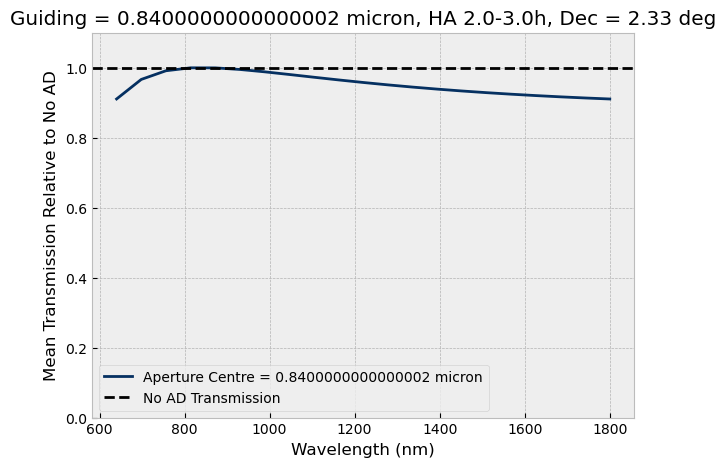

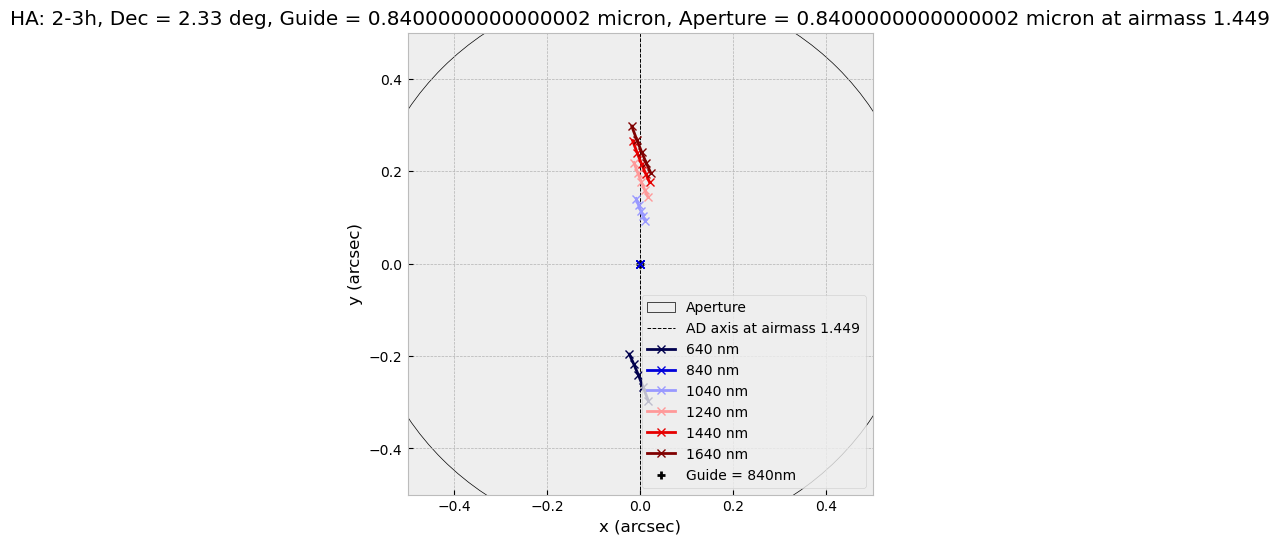

In [5]:
aperture_centres=np.arange(0.6,1.8,0.02)*u.micron

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,58) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(2,3,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat",scale=0.1)

best_metric=0
best_guide=0
best_aperture=0
for guide in aperture_centres:
    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic=True,centring="mid HA")
    for count,i in enumerate(integ_transmissions):
        current_metric=int_analysis.integ_metric(np.array(i)/np.array(opt_transmission),"min trans")
        if current_metric > best_metric:
            best_guide = guide
            best_metric=current_metric
            best_aperture=aperture_centres[count]
            
guide=best_guide
aperture_centres=[best_aperture]

integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic=True,centring="mid HA")
final_metric=int_analysis.integ_metric(np.array(integ_transmissions[0])/np.array(opt_transmission),"min trans")
print("Best guide:")
print(best_guide)
print("Best aperture:")
print(best_aperture)
print("Best metric:")
print(best_metric)
print("====")
print(final_metric)

guide=best_guide
aperture_centres=[best_aperture]
plot_integ_trans(aperture_centres,guide,analysis,centring="mid airmass")

analysis.output['wavelengths']= np.arange(640,1800+1,200) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=[2,2.25,2.5,2.75,3],targ_dec=2.33*u.deg)
analysis.calculate_shifts(guide,aperture_centres[0],centring="mid airmass")

int_analysis.track_plot(analysis,y_axis="centring")

Target goes below Horizon above/below HA of +/- 5.9h
0.9017657875250704
Target goes below Horizon above/below HA of +/- 5.9h


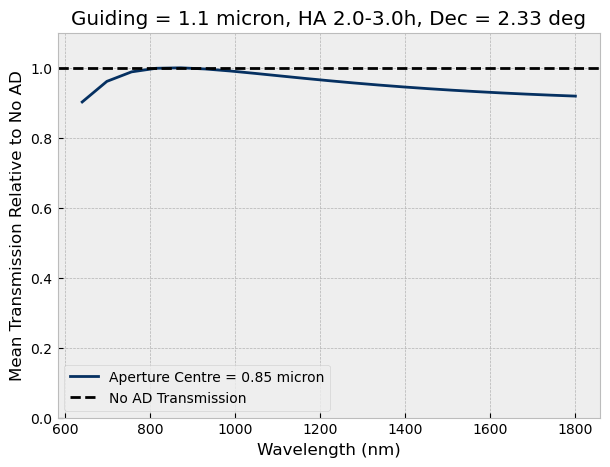

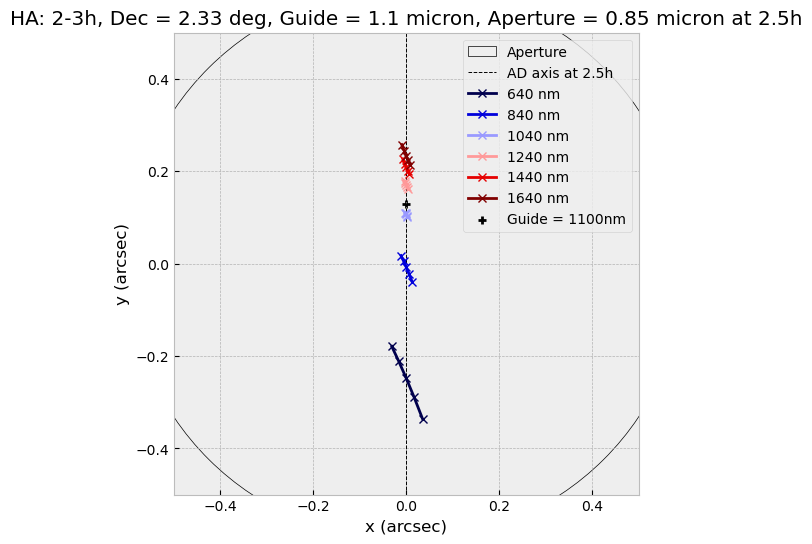

In [6]:
analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,58) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(2,3,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat",scale=0.1)
guide=1.1*u.micron
aperture_centres=[.85]*u.micron
plot_integ_trans(aperture_centres,guide,analysis,centring="mid HA")

analysis.output['wavelengths']= np.arange(640,1800+1,200) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=[2,2.25,2.5,2.75,3],targ_dec=2.33*u.deg)
analysis.calculate_shifts(guide,aperture_centres[0],centring="mid HA")

int_analysis.track_plot(analysis,y_axis="centring")

In [15]:
#Following function plots integration transmission average for single mode observations
def plot_integ_trans(aperture_centres,guide,analysis,parallatic=True,normalise="none"):  
    """
    normalise: string, "none", "no ad"
        what to normalise the transmission to; either no normalisation, or relative to the no AD case (perfect ADC)

    """
    weights = np.arange(0, len(aperture_centres)+1)
    norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.RdBu)

    integ_transmissions,opt_transmission=int_analysis.integ_trans(analysis,aperture_centres,guide,parallatic,centring="mid HA")
    
    plt.figure(figsize=[7,5])

    for count,i in enumerate(integ_transmissions):
        plt.plot(analysis.output['wavelengths'],np.array(i)/np.array(opt_transmission),label='Aperture Centre = {}'.format(aperture_centres[count]),color=cmap.to_rgba(len(aperture_centres)-count))
        print(int_analysis.integ_metric(np.array(i)/np.array(opt_transmission),"min trans"))
    plt.axhline(y=1,label='No AD Transmission',color='black',linestyle='--')
    plt.ylabel("Mean Transmission Relative to No AD")
    
    plt.legend()
    plt.title("Guiding = {}, HA {}-{}h, Dec = {}".format(guide,analysis.input['HA_range'][0],analysis.input['HA_range'][-1],analysis.input['targ_dec']))

    plt.ylim(0,1.1)
    plt.xlabel("Wavelength (nm)")
    
    


Target goes below Horizon above/below HA of +/- 5.9h
0.9772094244093127
Target goes below Horizon above/below HA of +/- 5.9h
0.977791265318153
Target goes below Horizon above/below HA of +/- 5.9h
0.9778523669494202
Target goes below Horizon above/below HA of +/- 5.9h
0.9582447329541187
Target goes below Horizon above/below HA of +/- 5.9h
0.8940293782446144


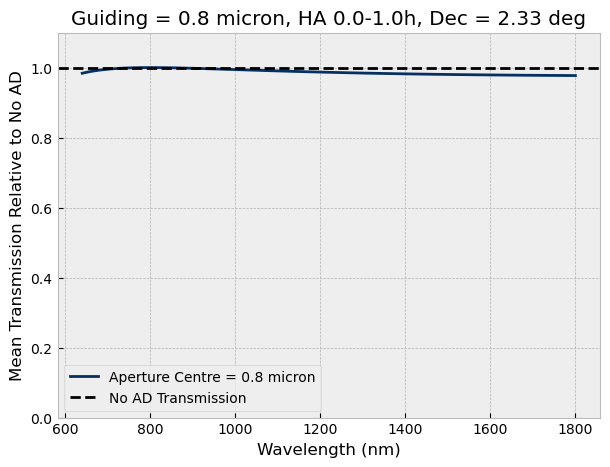

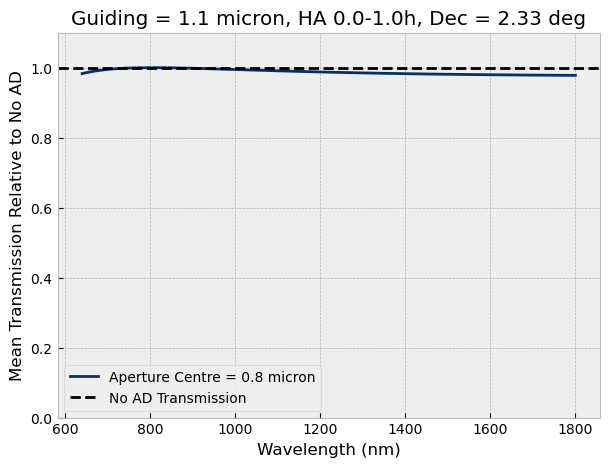

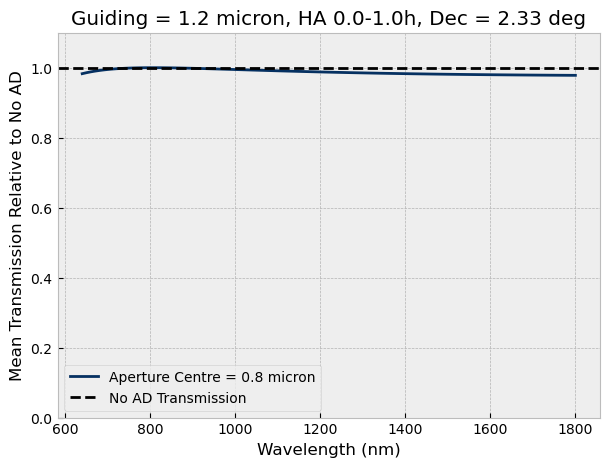

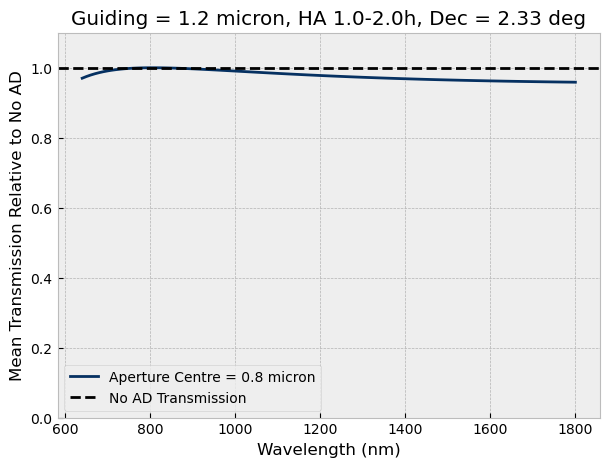

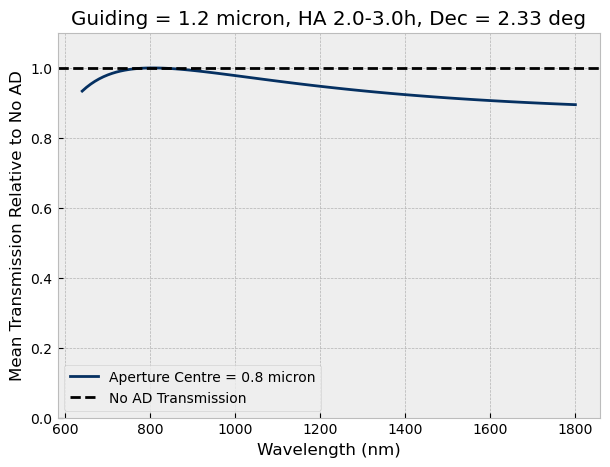

In [16]:
analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(0,1,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
aperture_centres=[.8*u.micron]
guide=.8*u.micron
plot_integ_trans(aperture_centres,guide,analysis)
airmass1=analysis.output['airmasses']

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(0,1,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
aperture_centres=[.8*u.micron]
guide=1.1*u.micron
plot_integ_trans(aperture_centres,guide,analysis)
airmass1=analysis.output['airmasses']

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(0,1,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
aperture_centres=[.8*u.micron]
guide=1.2*u.micron
plot_integ_trans(aperture_centres,guide,analysis)
airmass1=analysis.output['airmasses']



analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(1,2,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
airmass2=analysis.output['airmasses']

plot_integ_trans(aperture_centres,guide,analysis)


analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(HA_range=np.linspace(2,3,21),targ_dec=2.33*u.deg)
analysis.make_aperture("circle",method="numerical moffat")
airmass3=analysis.output['airmasses']
plot_integ_trans(aperture_centres,guide,analysis)


(0.0, 1.1)

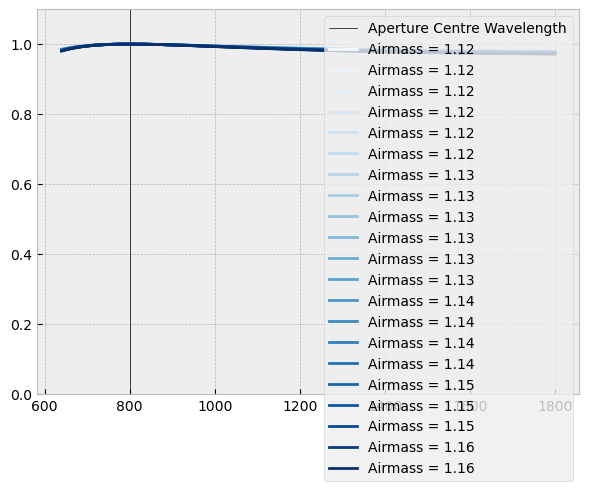

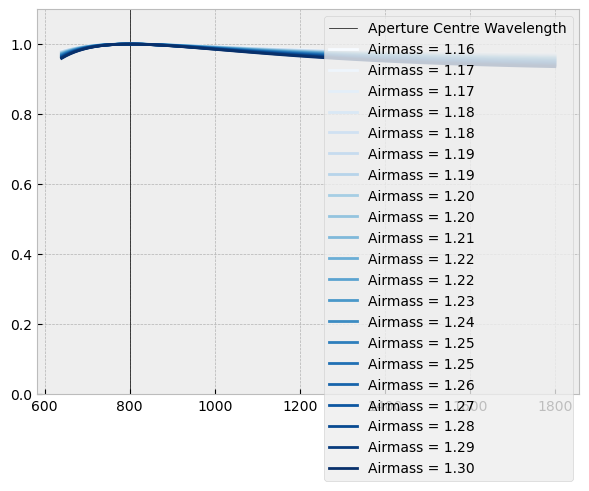

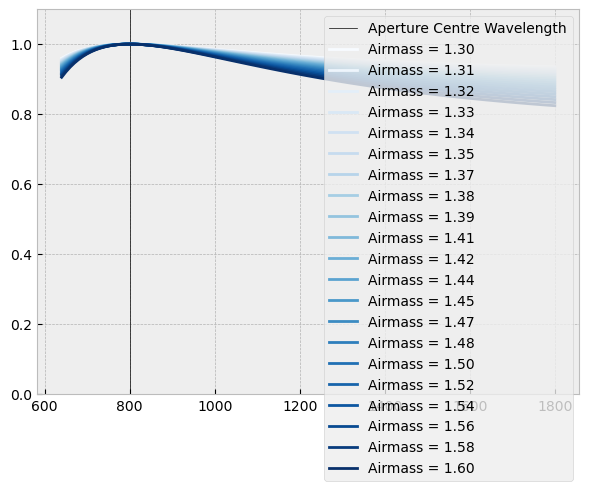

In [17]:
analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(airmasses=airmass1)
analysis.calculate_shifts(aperture_waveref = 0.8 * u.micron,reposition=True, guide_waveref=0.8 * u.micron,centring="mid HA")
analysis.make_aperture("circle",method="numerical moffat")
analysis.calculate_transmissions()
fig, ax = plt.subplots(figsize=(7,5))
wavelengths=analysis.output['wavelengths']
transmissions=analysis.output['transmissions']
weights = np.arange(1, len(analysis.output['airmasses'])+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
plt.axvline(0.8*1000,color='black',linewidth=0.5,label='Aperture Centre Wavelength')
for i in range(0,len(analysis.output['shifts'])):
    for o in range(0,len(analysis.output['shifts'][i])):
        analysis.output['shifts'][i][o]=0      
analysis.calculate_transmissions()
for i in range(0,len(transmissions)):
    plt.plot(wavelengths,np.array(transmissions[i])/np.array(analysis.output['transmissions'][i]),color=cmap.to_rgba(i+1),label="Airmass = %2.2f" %(analysis.output['airmasses'][i]),linestyle='-')    
plt.legend()
plt.ylim(0,1.1)

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(airmasses=airmass2)
analysis.calculate_shifts(aperture_waveref = 0.8 * u.micron,reposition=True, guide_waveref=0.8 * u.micron,centring="mid HA")
analysis.make_aperture("circle",method="numerical moffat")
analysis.calculate_transmissions()
fig, ax = plt.subplots(figsize=(7,5))
wavelengths=analysis.output['wavelengths']
transmissions=analysis.output['transmissions']
weights = np.arange(1, len(analysis.output['airmasses'])+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
plt.axvline(0.8*1000,color='black',linewidth=0.5,label='Aperture Centre Wavelength')
for i in range(0,len(analysis.output['shifts'])):
    for o in range(0,len(analysis.output['shifts'][i])):
        analysis.output['shifts'][i][o]=0      
analysis.calculate_transmissions()
for i in range(0,len(transmissions)):
    plt.plot(wavelengths,np.array(transmissions[i])/np.array(analysis.output['transmissions'][i]),color=cmap.to_rgba(i+1),label="Airmass = %2.2f" %(analysis.output['airmasses'][i]),linestyle='-')    
plt.legend()
plt.ylim(0,1.1)

analysis=AD_analysis()
analysis.output['wavelengths']= np.arange(640,1800+1,10) * u.nm
analysis.output['aperture_diameter'] = 1.2 * u.arcsec
analysis.load_airmasses(airmasses=airmass3)
analysis.calculate_shifts(aperture_waveref = 0.8 * u.micron,reposition=True, guide_waveref=0.8 * u.micron)
analysis.make_aperture("circle",method="numerical moffat")
analysis.calculate_transmissions()
fig, ax = plt.subplots(figsize=(7,5))
wavelengths=analysis.output['wavelengths']
transmissions=analysis.output['transmissions']
weights = np.arange(1, len(analysis.output['airmasses'])+1)
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Blues)
plt.axvline(0.8*1000,color='black',linewidth=0.5,label='Aperture Centre Wavelength')
for i in range(0,len(analysis.output['shifts'])):
    for o in range(0,len(analysis.output['shifts'][i])):
        analysis.output['shifts'][i][o]=0      
analysis.calculate_transmissions()
for i in range(0,len(transmissions)):
    plt.plot(wavelengths,np.array(transmissions[i])/np.array(analysis.output['transmissions'][i]),color=cmap.to_rgba(i+1),label="Airmass = %2.2f" %(analysis.output['airmasses'][i]),linestyle='-')    
plt.legend()
plt.ylim(0,1.1)